In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

from tqdm import tqdm

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute, QuantumCircuit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.extensions.unitary import UnitaryGate

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex

In [2]:
class Agent:
    
    def __init__(self, epsilon):
        self.reward_count = 0
        self.epsilon = epsilon
        
    def get_reward(self):
        self.reward_count += 1
        self.epsilon = (1+2*self.reward_count)/(100+2*self.reward_count)

In [73]:
class World:
    
    def __init__(self, initial_epsilon, combined_strategy_thresh=0.396):
        self.initial_epsilon = initial_epsilon
        self.circuit = self.init_circuit(initial_epsilon)
        self.combined_strategy_thresh = combined_strategy_thresh
        self.stop_quantum = False
        
    def combined_strategy(self, agent):
        epsilon = agent.epsilon
        reward_one = None

        if not self.stop_quantum:
            new_epsilon = self.quantum_epoch(epsilon)
        else:
            epsilon = agent.epsilon
            reward_one = self.classical_epoch(epsilon)
            if reward_one == 1:
                agent.get_reward()
            new_epsilon = epsilon
            
        reward_two = self.classical_epoch(new_epsilon)
        if reward_two == 1:
            agent.get_reward()
            
        if agent.epsilon > self.combined_strategy_thresh:
            self.stop_quantum = True
        
        if reward_one:
            return [reward_one, reward_two]
        else:
            return [reward_two/2, reward_two/2]
    
    def classical_strategy(self, agent):
        reward_one= self.classical_epoch(agent.epsilon)
        if reward_one == 1:
            agent.get_reward()
        
        reward_two = self.classical_epoch(agent.epsilon)
        if reward_two == 1:
            agent.get_reward()
        
        return [reward_one, reward_two]
    
    def quantum_strategy(self, agent):
        new_epsilon = self.quantum_epoch(agent.epsilon)
        reward = self.classical_epoch(new_epsilon)
        if reward == 1:
            agent.get_reward()
        return [reward/2, reward/2]
    
    def classical_epoch(self, epsilon):
        return np.random.choice(np.arange(0, 2), p = [1-epsilon, epsilon])
    
    def quantum_epoch(self, epsilon):
        self.circuit = self.init_circuit(epsilon)
        new_epsilon = Statevector.from_instruction(self.circuit).data.real[1]**2
        return new_epsilon
        
    def init_circuit(self, epsilon):
        circuit = QuantumCircuit(1)
        circuit.initialize([math.sqrt(1-epsilon), math.sqrt(epsilon)], 0)
        circuit.z(0)
        circuit.append(self.diffusion(epsilon), [0])
        return circuit
    
    def diffusion(self, epsilon):
        a = Statevector([math.sqrt(1-epsilon), 
                         math.sqrt(epsilon)])
        density = DensityMatrix(2*np.outer(a, a)-np.identity(2))
        c = UnitaryGate(density)
        return c

In [74]:
class Experiment:
    
    def __init__(self, 
                 n_agents=1024, 
                 initial_epsilon=1/100, 
                 epochs=400, 
                 combined_strategy_thresh=0.396, 
                 strategies=None):
        
        self.n_agents = n_agents
        self.initial_epsilon = initial_epsilon
        self.epochs = epochs
        self.combined_strategy_thresh = combined_strategy_thresh
        self.strategies = ["combined"] if not strategies else strategies
        
        self.logs_reward = {strategy: np.zeros((n_agents, epochs)) 
                            for strategy in self.strategies}
        self.logs_epsilon = {strategy: np.zeros((n_agents, epochs)) 
                            for strategy in self.strategies}
        
    def perform_complete_experiment(self):
        for strategy in self.strategies:
            print(f"Starting {strategy}")
            for agent in tqdm(range(self.n_agents)):
                self.perform_single_run(agent, strategy)
                
        
    def perform_single_run(self, agent_num, strategy):
        agent = Agent(epsilon = self.initial_epsilon)
        world = World(agent.epsilon, self.combined_strategy_thresh)

        for e in range(self.epochs):
            if strategy == "quantum":
                r = world.quantum_strategy(agent)
                    
            elif strategy == "classical":
                r = world.classical_strategy(agent)
            
            elif strategy == "combined":
                r = world.combined_strategy(agent)
            
            else:
                raise NotImplementedError
                
            self.logs_reward[strategy][agent_num, e] = r[1]
            self.logs_epsilon[strategy][agent_num, e] = agent.epsilon
            
    def plot_results(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
        for strategy in ex.strategies:
            rewards = ex.logs_reward[strategy].mean(axis=0)
            axes[0].plot(rewards, label=strategy)
            rewards = ex.logs_epsilon[strategy].mean(axis=0)
            axes[1].plot(rewards, label=strategy)
            
        axes[0].legend()
        axes[0].set_title(f"Average rewards(n={self.n_agents}) over epochs")
        axes[1].legend()
        axes[1].set_title(f"Average epsilon(n={self.n_agents}) over epochs")
        
        fig.savefig(f"results__n_agents={self.n_agents}__thresh_combined={self.combined_strategy_thresh}.png")

In [ ]:
ex = Experiment(strategies=["classical", "quantum", "combined"], n_agents=256, epochs=500)
ex.perform_complete_experiment()

Starting classical


100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:01<00:00, 33.15it/s]


Starting quantum


 64%|██████████████████████████████████████████████████████▌                               | 6351/10000 [1:42:26<51:36,  1.18it/s]

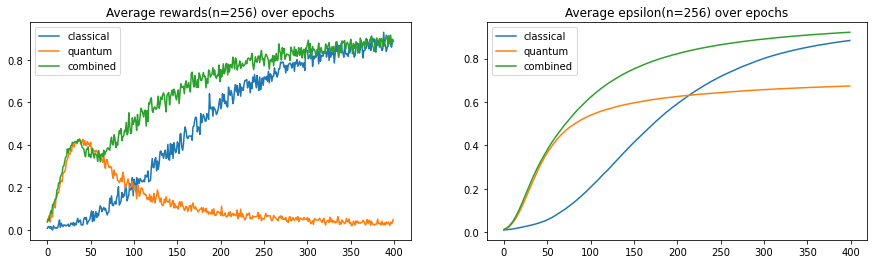

In [76]:
ex.plot_results()